<a href="https://colab.research.google.com/github/thevirusoup/thevirusoup/blob/main/ngs_transcriptome_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Overview
This tutorial will guide you through a complete RNA-seq (transcriptome) analysis pipeline using Mycobacterium tuberculosis data. We'll analyze how antibiotic treatment affects gene expression patterns in this important pathogen.

##What you'll learn:
* Download and process raw sequencing data
* Perform quality control checks
* Align reads to a reference genome
* Count gene expression levels
* Identify differentially expressed genes
* Visualize results

##Step 1: Mount Google Drive

**What this does:** Connects your Google Colab session to your Google Drive so you can save and access files.

**Why it's important:** All your analysis results will be stored in Google Drive, making them persistent across sessions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##Step 2: Create Project Directory Structure

**What this does:** Creates organized folders for your transcriptomics project with separate directories for raw data, reference files, and results.

**Why it's important:** Good organization helps you keep track of files and makes your analysis reproducible. This follows bioinformatics best practices.  

**Folder structure created:**

`RawData`: Stores downloaded FASTQ files  
`Reference`: Stores genome and annotation files  
`Results`: Stores all analysis outputs

In [ ]:
import os

# Base path in your Google Drive
base_path = '/content/drive/MyDrive/MT_Transcriptomics/'

# Define folder paths
raw_data_dir = os.path.join(base_path, 'RawData')
reference_dir = os.path.join(base_path, 'Reference')
results_dir = os.path.join(base_path, 'Results')

# Create folders if they don't exist
for folder in [raw_data_dir, reference_dir, results_dir]:
    os.makedirs(folder, exist_ok=True)

print(f"Folders created at: {base_path}")


Folders created at: /content/drive/MyDrive/MT_Transcriptomics/


##Step 3: Create FastQC Output Directory

**What this does:** Creates a specific subfolder for quality control reports.

**Why it's important:** FastQC generates HTML reports that help us assess the quality of our sequencing data. Having a dedicated folder keeps these reports organized.

In [ ]:
import os

fastqc_out_dir = '/content/drive/MyDrive/MT_Transcriptomics/Results/FastQC_Reports'
os.makedirs(fastqc_out_dir, exist_ok=True)
print(f"Created directory: {fastqc_out_dir}")


Created directory: /content/drive/MyDrive/MT_Transcriptomics/Results/FastQC_Reports


##Step 4: Install SRA Toolkit
**What this does:** Installs the NCBI SRA (Sequence Read Archive) Toolkit, which allows us to download sequencing data from public databases.

**Why it's important:** Most published RNA-seq data is stored in NCBI's SRA database. The SRA Toolkit provides commands like prefetch and fasterq-dump to download and convert this data.

**Key tools installed:**  
`prefetch`: Downloads SRA files  
`fasterq-dump`: Converts SRA files to FASTQ format

In [ ]:
# Install SRA Toolkit
!apt-get update
!apt-get install -y sra-toolkit

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,765 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,984 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,017 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu

##Step 5: Download and Process RNA-seq Data

**What this does:** Downloads specific M. tuberculosis RNA-seq datasets from NCBI SRA, converts them to FASTQ format, and compresses them for storage efficiency.

**Dataset details:**

* SRR1140638: Antibiotic-treated sample

* SRR1062940: Control sample

* SRR1049749: Antibiotic-treated replicate

* SRR1049750: Control replicate

**Process steps:**

* Downloads .sra files using prefetch
* Converts to paired-end FASTQ files using fasterq-dump --split-files
* Compresses FASTQ files with gzip to save space
* Cleans up intermediate files

**Why paired-end:** Modern RNA-seq uses paired-end sequencing, which sequences both ends of DNA fragments, providing better mapping accuracy and ability to detect splice junctions.

In [ ]:
import os
import glob

# List of SRA runs to download
sra_runs = [
    'SRR1140638',  # Antibiotic treated
    'SRR1062940',  # Control
    'SRR1049749',  # Antibiotic treated replicate
    'SRR1049750'   # Control replicate
]

# Path to store raw FASTQ files
fastq_path = raw_data_dir  # Assuming raw_data_dir is defined

for run in sra_runs:
    print(f"Downloading {run} ...")
    !prefetch {run} --output-directory {fastq_path}

    sra_file = os.path.join(fastq_path, run, f"{run}.sra")
    print(f"Converting {run} to FASTQ ...")
    # Convert without --gzip
    !fasterq-dump {sra_file} -O {fastq_path} --split-files

    # Compress the generated FASTQ files
    fq1 = os.path.join(fastq_path, f"{run}_1.fastq")
    fq2 = os.path.join(fastq_path, f"{run}_2.fastq")

    if os.path.exists(fq1):
        print(f"Compressing {fq1} ...")
        !gzip {fq1}
    else:
        print(f"Warning: {fq1} not found!")

    if os.path.exists(fq2):
        print(f"Compressing {fq2} ...")
        !gzip {fq2}
    else:
        print(f"Warning: {fq2} not found!")

    # Remove .sra file after conversion
    if os.path.exists(sra_file):
        print(f"Removing .sra file for {run} ...")
        os.remove(sra_file)

    # Remove empty directory if exists
    run_dir = os.path.join(fastq_path, run)
    if os.path.isdir(run_dir):
        try:
            os.rmdir(run_dir)
            print(f"Removed empty directory {run_dir}")
        except OSError:
            print(f"Directory {run_dir} not empty or could not be removed.")

print("Download and conversion complete.")



2025-06-10T04:18:52 prefetch.2.11.3: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2025-06-10T04:18:52 prefetch.2.11.3: 1) Downloading 'SRR1140638'...
2025-06-10T04:18:52 prefetch.2.11.3: SRA Normalized Format file is being retrieved, if this is different from your preference, it may be due to current file availability.
2025-06-10T04:18:52 prefetch.2.11.3:  Downloading via HTTPS...
2025-06-10T04:18:58 prefetch.2.11.3:  HTTPS download succeed
2025-06-10T04:18:59 prefetch.2.11.3:  'SRR1140638' is valid
2025-06-10T04:18:59 prefetch.2.11.3: 1) 'SRR1140638' was downloaded successfully
2025-06-10T04:18:59 prefetch.2.11.3: 'SRR1140638' has 0 unresolved dependencies
Converting SRR1140638 to FASTQ ...
spots read      : 2,147,113
reads read      : 4,294,226
reads written   : 4,294,226
Compressing /content/drive/MyDrive/MT_Transcriptomics/RawData/SRR1140638_1.fastq ...
Compressing /content/drive/MyDrive/MT_Transcriptomics/RawData/SRR1140638_2.fa

##Step 6: Download Reference Genome and Annotations
**What this does:** Downloads the M. tuberculosis H37Rv reference genome sequence (FASTA) and its gene annotations (GFF) from NCBI.  

**Why we need this:**
* Reference genome: Required for aligning RNA-seq reads to determine where they came from
* Gene annotations: Tell us where genes are located so we can count how many reads map to each gene

**Files to download:**
* GCF_000195955.2_ASM19595v2_genomic.fna: Complete genome sequence
* GCF_000195955.2_ASM19595v2_genomic.gff: Gene locations and features


In [ ]:
# Create folder for Mycobacterium tuberculosis reference genome if not already created
!mkdir -p /content/drive/MyDrive/MT_Transcriptomics/Reference

# Download Mycobacterium tuberculosis H37Rv reference genome (FASTA)
!wget -P /content/drive/MyDrive/MT_Transcriptomics/Reference/ \
https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/195/955/GCF_000195955.2_ASM19595v2/GCF_000195955.2_ASM19595v2_genomic.fna.gz

# Download corresponding annotation file (GFF format)
!wget -P /content/drive/MyDrive/MT_Transcriptomics/Reference/ \
https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/195/955/GCF_000195955.2_ASM19595v2/GCF_000195955.2_ASM19595v2_genomic.gff.gz

# Unzip downloaded files
!gunzip /content/drive/MyDrive/MT_Transcriptomics/Reference/*.gz


--2025-06-10 04:31:16--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/195/955/GCF_000195955.2_ASM19595v2/GCF_000195955.2_ASM19595v2_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.7, 130.14.250.10, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1277508 (1.2M) [application/x-gzip]
Saving to: ‘/content/drive/MyDrive/MT_Transcriptomics/Reference/GCF_000195955.2_ASM19595v2_genomic.fna.gz’

GCF_000195955.2_ASM 100%[===================>]   1.22M  4.62MB/s    in 0.3s    

2025-06-10 04:31:16 (4.62 MB/s) - ‘/content/drive/MyDrive/MT_Transcriptomics/Reference/GCF_000195955.2_ASM19595v2_genomic.fna.gz’ saved [1277508/1277508]

--2025-06-10 04:31:16--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/195/955/GCF_000195955.2_ASM19595v2/GCF_000195955.2_ASM19595v2_genomic.gff.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250

##Step 7: Quality Control with FastQC
**What this does:** Runs FastQC on all FASTQ files to generate quality reports that help assess the quality of your sequencing data.  
**What FastQC checks:**
* Per-base sequence quality scores
* Sequence length distribution
* GC content
* Presence of adapter sequences
* Over-represented sequences
* Duplication levels

**Why it's important:** Poor quality data can lead to incorrect results. FastQC helps identify issues like:
* Low quality bases that need trimming
* Adapter contamination
* Unusual sequence composition

**Output:** HTML reports for each FASTQ file showing various quality metrics with pass/warning/fail status.

In [ ]:
# Install FastQC
!apt-get install -y default-jre
!wget https://www.bioinformatics.babraham.ac.uk/projects/fastqc/fastqc_v0.12.1.zip
!unzip fastqc_v0.12.1.zip
!chmod +x FastQC/fastqc
!ln -s /content/FastQC/fastqc /usr/local/bin/fastqc


# Run FastQC on all raw FASTQ files in your RawData folder
!fastqc /content/drive/MyDrive/MT_Transcriptomics/RawData/*.fastq.gz -o /content/drive/MyDrive/MT_Transcriptomics/Results/FastQC_Reports


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  default-jre-headless fonts-dejavu-core fonts-dejavu-extra
  libatk-wrapper-java libatk-wrapper-java-jni libxtst6 libxxf86dga1
  openjdk-11-jre x11-utils
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  default-jre default-jre-headless fonts-dejavu-core fonts-dejavu-extra
  libatk-wrapper-java libatk-wrapper-java-jni libxtst6 libxxf86dga1
  openjdk-11-jre x11-utils
0 upgraded, 10 newly installed, 0 to remove and 42 not upgraded.
Need to get 3,634 kB of archives.
After this operation, 12.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3,042 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxtst6 amd64 2:1.2.3-1build4 [13.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-

##Step 8: Build HISAT2 Index
**What this does:** Creates an index of the reference genome that allows the HISAT2 aligner to quickly find potential alignment locations for sequencing reads.

**Why indexing is needed:**
* Raw genome files are too large to search efficiently
* Indexes use data structures (like suffix arrays) that enable rapid sequence searching
* Similar to creating an index in a book - makes finding information much faster

**HISAT2 advantages:**
* Designed specifically for RNA-seq data
* Can handle splice junctions (where exons are joined)
* Memory efficient and fast
* Successor to TopHat/Bowtie2 pipeline

In [ ]:
# Install HISAT2
!wget https://cloud.biohpc.swmed.edu/index.php/s/hisat2-220-Linux_x86_64/download -O hisat2-2.2.0-Linux_x86_64.zip
!unzip hisat2-2.2.0-Linux_x86_64.zip
!chmod +x hisat2-2.2.0/hisat2*
!cp hisat2-2.2.0/hisat2* /usr/local/bin/


# Define correct paths for MTB
reference_fasta="/content/drive/MyDrive/MT_Transcriptomics/Reference/GCF_000195955.2_ASM19595v2_genomic.fna"
hisat2_index_base="/content/drive/MyDrive/MT_Transcriptomics/Reference/mtb_index"

# Build HISAT2 index
!hisat2-build $reference_fasta $hisat2_index_base


--2025-06-10 04:44:40--  https://cloud.biohpc.swmed.edu/index.php/s/hisat2-220-Linux_x86_64/download
Resolving cloud.biohpc.swmed.edu (cloud.biohpc.swmed.edu)... 129.112.9.92
Connecting to cloud.biohpc.swmed.edu (cloud.biohpc.swmed.edu)|129.112.9.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35400686 (34M) [application/zip]
Saving to: ‘hisat2-2.2.0-Linux_x86_64.zip’

hisat2-2.2.0-Linux_ 100%[===================>]  33.76M  86.7MB/s    in 0.4s    

2025-06-10 04:44:41 (86.7 MB/s) - ‘hisat2-2.2.0-Linux_x86_64.zip’ saved [35400686/35400686]

Archive:  hisat2-2.2.0-Linux_x86_64.zip
   creating: hisat2-2.2.0/
   creating: hisat2-2.2.0/scripts/
  inflating: hisat2-2.2.0/scripts/make_b_taurus_UMD3.sh  
  inflating: hisat2-2.2.0/scripts/make_grch38.sh  
  inflating: hisat2-2.2.0/scripts/make_e_coli.sh  
  inflating: hisat2-2.2.0/scripts/make_grch37_snp.sh  
  inflating: hisat2-2.2.0/scripts/make_grcm38_tran.sh  
  inflating: hisat2-2.2.0/scripts/make_hg19.sh  
  i

##Step 9: Align Reads and Generate BAM Files
**What this does:** Aligns paired-end RNA-seq reads to the reference genome using HISAT2, then converts and processes the output into sorted, indexed BAM files.  

**Process workflow:**
* Alignment: HISAT2 aligns reads to reference genome, output as SAM
* Conversion: Convert SAM (text) to BAM (binary) format for efficiency
* Sorting: Sort BAM by genomic coordinates for downstream tools
* Indexing: Create BAM index (.bai) for rapid random access
* Cleanup: Remove intermediate files to save space

**Why each step matters:**
* SAM→BAM: BAM files are ~4x smaller and faster to process
* Sorting: Required for most downstream tools (variant calling, visualization)
* Indexing: Allows tools to quickly jump to specific genomic regions

**`Output`:** One sorted, indexed BAM file per sample containing all aligned reads.

In [ ]:
!apt-get update
!apt-get install -y samtools


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 257 kB in 1s (203 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package list

In [ ]:
import subprocess
import glob
import os

raw_data_dir = '/content/drive/MyDrive/MT_Transcriptomics/RawData'
results_dir = '/content/drive/MyDrive/MT_Transcriptomics/Results/Alignments'
os.makedirs(results_dir, exist_ok=True)

# Use the correct HISAT2 index base path (without extension)
hisat2_index_base = '/content/drive/MyDrive/MT_Transcriptomics/Reference/mtb_index'

# List all R1 FASTQ files
r1_files = sorted(glob.glob(os.path.join(raw_data_dir, '*_1.fastq.gz')))

for r1 in r1_files:
    r2 = r1.replace('_1.fastq.gz', '_2.fastq.gz')
    sample_name = os.path.basename(r1).split('_1.fastq.gz')[0]

    sam_out = os.path.join(results_dir, sample_name + '.sam')
    bam_unsorted = os.path.join(results_dir, sample_name + '.bam')
    bam_sorted = os.path.join(results_dir, sample_name + '.sorted.bam')

    print(f"Aligning sample {sample_name} ...")
    try:
        subprocess.run(
            ['hisat2', '-x', hisat2_index_base, '-1', r1, '-2', r2, '-S', sam_out],
            check=True
        )
    except subprocess.CalledProcessError:
        print(f"Error: HISAT2 alignment failed for sample {sample_name}. Skipping this sample.")
        continue

    print(f"Converting SAM to BAM for sample {sample_name} ...")
    try:
        subprocess.run(['samtools', 'view', '-bS', sam_out, '-o', bam_unsorted], check=True)
    except subprocess.CalledProcessError:
        print(f"Error: samtools view failed for sample {sample_name}. Skipping this sample.")
        continue

    print(f"Sorting BAM file for sample {sample_name} ...")
    try:
        subprocess.run(['samtools', 'sort', '-o', bam_sorted, bam_unsorted], check=True)
    except subprocess.CalledProcessError:
        print(f"Error: samtools sort failed for sample {sample_name}. Skipping this sample.")
        continue

    print(f"Indexing sorted BAM for sample {sample_name} ...")
    try:
        subprocess.run(['samtools', 'index', bam_sorted], check=True)
    except subprocess.CalledProcessError:
        print(f"Error: samtools index failed for sample {sample_name}. Skipping this sample.")
        continue

    print(f"Cleaning up intermediate files for sample {sample_name} ...")
    try:
        os.remove(sam_out)
        os.remove(bam_unsorted)
    except FileNotFoundError as e:
        print(f"Warning: file not found during cleanup: {e}")

print("Alignment and BAM processing complete.")


Aligning sample SRR1049749 ...
Converting SAM to BAM for sample SRR1049749 ...
Sorting BAM file for sample SRR1049749 ...
Indexing sorted BAM for sample SRR1049749 ...
Cleaning up intermediate files for sample SRR1049749 ...
Aligning sample SRR1049750 ...
Converting SAM to BAM for sample SRR1049750 ...
Sorting BAM file for sample SRR1049750 ...
Indexing sorted BAM for sample SRR1049750 ...
Cleaning up intermediate files for sample SRR1049750 ...
Aligning sample SRR1062940 ...
Converting SAM to BAM for sample SRR1062940 ...
Sorting BAM file for sample SRR1062940 ...
Indexing sorted BAM for sample SRR1062940 ...
Cleaning up intermediate files for sample SRR1062940 ...
Aligning sample SRR1140638 ...
Converting SAM to BAM for sample SRR1140638 ...
Sorting BAM file for sample SRR1140638 ...
Indexing sorted BAM for sample SRR1140638 ...
Cleaning up intermediate files for sample SRR1140638 ...
Alignment and BAM processing complete.


##Step 10: Convert GFF to GTF Format
**What this does:** Converts the gene annotation file from GFF3 format to GTF format using gffread.  
**Why this conversion is needed:**
* GFF3: General Feature Format version 3, more flexible but complex
* GTF: Gene Transfer Format, simpler and required by many RNA-seq tools. `featureCounts` (our counting tool) works better with GTF format

**What gffread does:**
* Parses GFF3 hierarchical gene structures
* Outputs simplified GTF with gene/transcript/exon features
* Maintains essential information needed for read counting

In [ ]:
#!apt-get install -y gffread
!apt-get update
!apt-get install -y gffread



Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
!gffread /content/drive/MyDrive/MT_Transcriptomics/Reference/GCF_000195955.2_ASM19595v2_genomic.gff -T -o /content/drive/MyDrive/MT_Transcriptomics/Reference/GCF_000195955.2_ASM19595v2_genomic.gtf


##Step 11: Count Gene Expression with featureCounts
**What this does:** Counts how many sequencing reads map to each gene using featureCounts from the Subread package.  
**Key parameters:**  
* `-p`: Specifies paired-end reads (counts fragments, not individual reads)
* `-s 2`: Reverse-stranded library (common for many RNA-seq protocols)
* `-F GTF`: Input annotation format is GTF
* `-g transcript_id`: Group features by transcript ID for counting
* `-t CDS`: Count reads mapping to coding sequences only

**Why gene counting is important:**
* Converts alignment data into expression levels
* Each gene gets a count representing its expression level
* Higher counts = higher gene expression
* These counts become input for differential expression analysis

**Output:** A tab-delimited file with genes as rows and samples as columns, containing raw read counts.

In [ ]:
# Install subread (featureCounts)
!apt-get install -y subread

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  subread
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 565 kB of archives.
After this operation, 1,928 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 subread amd64 2.0.3+dfsg-1 [565 kB]
Fetched 565 kB in 0s (2,120 kB/s)
Selecting previously unselected package subread.
(Reading database ... 126722 files and directories currently installed.)
Preparing to unpack .../subread_2.0.3+dfsg-1_amd64.deb ...
Unpacking subread (2.0.3+dfsg-1) ...
Setting up subread (2.0.3+dfsg-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
import glob
import os

# Directory where BAM files are stored
results_dir = "/content/drive/MyDrive/MT_Transcriptomics/Results/Alignments"

# Use the original GTF annotation file
reference_gtf = "/content/drive/MyDrive/MT_Transcriptomics/Reference/GCF_000195955.2_ASM19595v2_genomic.gtf"

# Collect sorted BAM files
bam_files = sorted(glob.glob(os.path.join(results_dir, '*.sorted.bam')))
bam_list_str = ' '.join(bam_files)

# Output counts file
counts_out = '/content/drive/MyDrive/MT_Transcriptomics/Results/gene_counts.txt'

# Run featureCounts with paired-end, reverse stranded (-s 2), specifying GTF format
!featureCounts -p -s 2 -F GTF -a {reference_gtf} -o {counts_out} -g transcript_id -t CDS {bam_list_str}


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.3

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 4 BAM files                                      ||
||                                                                            ||
||                           SRR1049749.sorted.bam                            ||
||                           SRR1049750.sorted.bam                            ||
||                           SRR1062940.sorted.bam               

##Step 12: Load and Examine Count Data
**What this does: **Loads the gene count matrix from featureCounts and examines its structure to understand the data format.  
**Understanding the output:**
* Geneid: Gene identifiers from the annotation
Chr, Start, End, Strand: Genomic coordinates of each gene
* Length: Gene length in base pairs
* Sample columns: Raw read counts for each sample

**Why we examine the data first:**
* Understand the file structure before analysis
* Check that all samples are present
* Verify that count data looks reasonable
* Identify column positions for downstream processing

In [ ]:
import pandas as pd

counts_file = "/content/drive/MyDrive/MT_Transcriptomics/Results/gene_counts.txt"

counts_df = pd.read_csv(counts_file, sep='\t', skiprows=1)
print(counts_df.columns)  # This should now show Geneid, Chr, Start, etc.

# Set the index to Geneid
counts_df.set_index('Geneid', inplace=True)

print(counts_df.head())


Index(['Geneid', 'Chr', 'Start', 'End', 'Strand', 'Length',
       '/content/drive/MyDrive/MT_Transcriptomics/Results/Alignments/SRR1049749.sorted.bam',
       '/content/drive/MyDrive/MT_Transcriptomics/Results/Alignments/SRR1049750.sorted.bam',
       '/content/drive/MyDrive/MT_Transcriptomics/Results/Alignments/SRR1062940.sorted.bam',
       '/content/drive/MyDrive/MT_Transcriptomics/Results/Alignments/SRR1140638.sorted.bam'],
      dtype='object')
                     Chr  Start   End Strand  Length  \
Geneid                                                 
gene-Rv0001  NC_000962.3      1  1524      +    1524   
gene-Rv0002  NC_000962.3   2052  3260      +    1209   
gene-Rv0003  NC_000962.3   3280  4437      +    1158   
gene-Rv0004  NC_000962.3   4434  4997      +     564   
gene-Rv0005  NC_000962.3   5240  7267      +    2028   

             /content/drive/MyDrive/MT_Transcriptomics/Results/Alignments/SRR1049749.sorted.bam  \
Geneid                                               

##Step 13: Filter Low-Expression Genes
**What this does:** Removes genes with very low expression levels (total counts < 10 across all samples) to improve statistical power and reduce multiple testing burden.

**Why filtering is important:**
* Noise reduction: Very low counts are often just noise
* Statistical power: Fewer tests = better p-value correction
* Computational efficiency: Fewer genes to analyze
* Biological relevance: Very lowly expressed genes may not be functionally important

**Common filtering approaches:**
* Total count threshold (used here: ≥10 total counts)
* CPM threshold (e.g., ≥1 CPM in ≥2 samples)
* FPKM threshold for longer transcripts

In [ ]:
# Filter genes with total counts >= 10 across all samples (or use counts per million threshold)
filtered_counts = counts_df[counts_df.iloc[:, 5:].sum(axis=1) >= 10]
print(f"Number of genes before filtering: {counts_df.shape[0]}")
print(f"Number of genes after filtering: {filtered_counts.shape[0]}")


Number of genes before filtering: 3906
Number of genes after filtering: 3878


##Step 14: Normalize to Counts Per Million (CPM)
**What this does:** Normalizes raw read counts to account for differences in sequencing depth (library size) between samples.  
**Why normalization is needed:**
Different samples may have different total read counts
We want to compare expression levels, not sequencing depth
CPM = (gene counts / total sample counts) × 1,000,000

**CPM advantages:**
* Simple and intuitive normalization
* Accounts for library size differences
* Widely used and understood
* Good for exploratory analysis and visualization

**Alternative normalizations:**
* RPKM/FPKM (accounts for gene length)
* TPM (transcripts per million)
* TMM (trimmed mean of M-values)

In [ ]:
sample_counts = filtered_counts.iloc[:, 6:]  # Only count columns
library_sizes = sample_counts.sum(axis=0)

cpm = sample_counts.divide(library_sizes, axis=1) * 1e6


##Step 15: Log2 Transform CPM Data
**What this does:** Applies log2 transformation to CPM values to make the data more suitable for statistical analysis and visualization.  
**Why log transformation is important:**
* Variance stabilization: Makes variance more consistent across expression levels
* Normal distribution: Log-transformed counts are more normally distributed
* Fold-change interpretation: Differences in log space represent fold changes
* Visualization: Makes expression patterns more visible in plots


In [ ]:
import numpy as np

log_cpm = np.log2(cpm + 1)


##Step 16: Principal Component Analysis (PCA)
**What this does:** Performs PCA on the log2-transformed CPM data to visualize sample relationships and identify potential batch effects or outliers.  
**What PCA shows:**
* Sample clustering: Similar samples cluster together
* Treatment effects: Treated vs control samples should separate
* Outliers: Samples that don't cluster as expected
* Batch effects: Unwanted technical variation between sample groups

**How to interpret:**
* PC1 (x-axis): Captures the most variation in the data
* PC2 (y-axis): Captures the second most variation
* Distance: Closer points = more similar gene expression profiles
* Good result: Clear separation between treatment groups

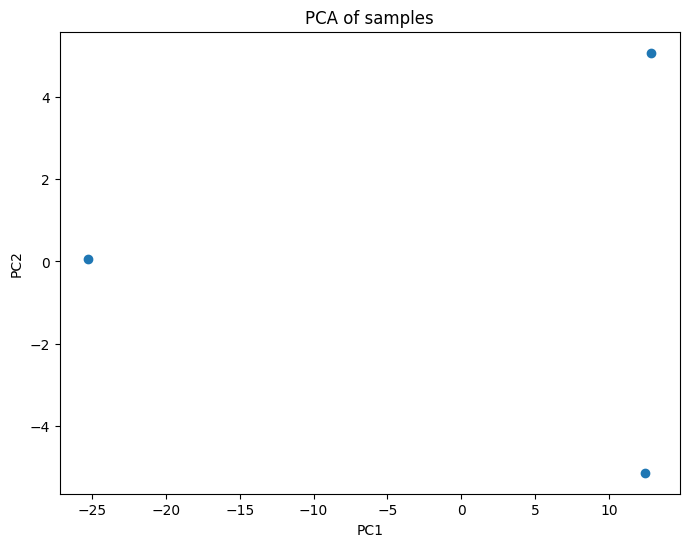

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(log_cpm.T)  # transpose to have samples as rows

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of samples')
plt.show()


##Step 17: Complete Data Processing and Visualization
**What this does:** Combines all preprocessing steps into a comprehensive workflow and creates an improved PCA plot with sample labels.   

**Complete workflow:**
* Filter lowly expressed genes (≥10 total counts)
* Calculate CPM normalization
* Apply log2 transformation
* Generate PCA plot with sample labels
* Save all processed data to files

**Why save intermediate files:**
* Reproducibility: Can restart analysis from any point
* Sharing: Others can use your processed data
* Backup: Prevents loss of computational work
* Downstream analysis: Processed data ready for other tools

Genes before filtering: 3906
Genes after filtering: 3878


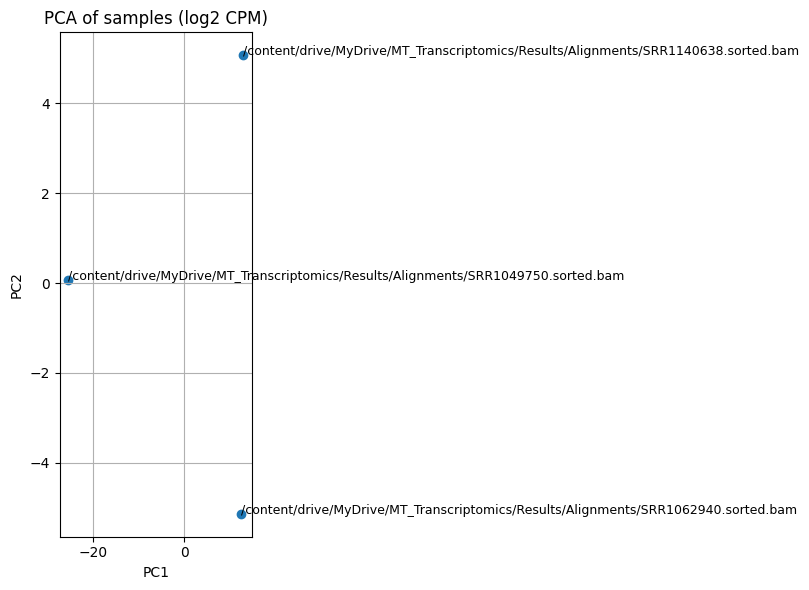

Filtered counts, CPM, and log2 CPM saved.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'counts_df' is already loaded with your featureCounts output
# and has annotation columns: Geneid, Chr, Start, End, Strand, Length
# Count data starts from the 7th column (index 6)

# Step 1: Filter lowly expressed genes (total counts >= 10 across samples)
count_data = counts_df.iloc[:, 6:]  # Select count columns only
filtered_counts = counts_df[count_data.sum(axis=1) >= 10]

print(f"Genes before filtering: {counts_df.shape[0]}")
print(f"Genes after filtering: {filtered_counts.shape[0]}")

# Step 2: Normalize to Counts Per Million (CPM)
filtered_count_data = filtered_counts.iloc[:, 6:]
library_sizes = filtered_count_data.sum(axis=0)
cpm = filtered_count_data.divide(library_sizes, axis=1) * 1e6

# Step 3: Log2 transform CPM (add pseudo-count 1)
log_cpm = np.log2(cpm + 1)

# Step 4: PCA plot of log2 CPM data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(log_cpm.T)  # samples as rows

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
for i, sample in enumerate(log_cpm.columns):
    plt.text(pca_result[i, 0], pca_result[i, 1], sample, fontsize=9)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of samples (log2 CPM)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Save results to files
filtered_counts.to_csv('/content/filtered_gene_counts.txt', sep='\t')
cpm.to_csv('/content/gene_cpm.txt', sep='\t')
log_cpm.to_csv('/content/gene_log2_cpm.txt', sep='\t')

print("Filtered counts, CPM, and log2 CPM saved.")


## Step 18: Install Statistical Analysis Packages
**What this does:** Installs Python packages needed for statistical analysis of differential gene expression.

**Packages installed:**
* pandas: Data manipulation and analysis
* numpy: Numerical computing
* statsmodels: Statistical modeling and tests

**Why these packages:**
* pandas: Essential for handling gene expression matrices
* numpy: Provides mathematical functions for data analysis
* statsmodels: Provides linear modeling capabilities for differential expression analysis



In [ ]:
pip install pandas numpy statsmodels


##Step 19: Differential Expression Analysis
**What this does:** Identifies genes that are significantly differentially expressed between antibiotic-treated and control samples using linear modeling.

**Analysis workflow:**
-Load data: Import count matrix from featureCounts  
-Create metadata: Define which samples are treated vs control  
-Filter genes: Remove lowly expressed genes  
-Transform data: Log2 transform for linear modeling  
-Build design matrix: Set up statistical model (treatment vs control)  
-Fit models: Run linear regression for each gene  
-Multiple testing correction: Adjust p-values using Benjamini-Hochberg FDR

**Statistical approach:**
* Linear model: Gene expression ~ treatment condition
* Log2 fold change: Coefficient represents log2(treated/control)
* P-value: Tests if fold change is significantly different from 0
* FDR correction: Controls false discovery rate in multiple comparisons

**Output:** Table with genes, fold changes, p-values, and adjusted p-values.

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os

# Step 1: Load counts file from featureCounts
counts_path = "/content/drive/MyDrive/MT_Transcriptomics/Results/gene_counts.txt"
counts_df = pd.read_csv(counts_path, sep='\t', comment='#')

# Inspect columns and simplify sample column names
print("Original columns:", counts_df.columns)

# Step 2: Extract raw counts matrix (samples start from 7th column, index 6)
count_data = counts_df.iloc[:, 6:].copy()

# Simplify sample names by keeping only filenames, not full paths
count_data.columns = [os.path.basename(x) for x in count_data.columns]

# Set gene IDs as index
count_data.index = counts_df['Geneid']

# Step 3: Create sample metadata DataFrame
# Example: first two samples are control, next two are treated - adjust as needed
sample_metadata = pd.DataFrame({
    'sample': count_data.columns,
    'condition': ['control', 'control', 'treated', 'treated']
}).set_index('sample')

print("Sample metadata:\n", sample_metadata)

# Step 4: Filter genes - keep genes with sum of counts > 10 across all samples
filtered_counts = count_data.loc[count_data.sum(axis=1) > 10, :]
print(f"Filtered from {count_data.shape[0]} to {filtered_counts.shape[0]} genes")

# Step 5: Log2 transform normalized counts (adding pseudocount 1)
log_counts = np.log2(filtered_counts + 1)

# Step 6: Build design matrix for linear modeling
# Ensure sample order matches between counts and metadata
conditions = sample_metadata.loc[filtered_counts.columns, 'condition']

design_matrix = pd.get_dummies(conditions, drop_first=True)  # 'treated' vs 'control'
design_matrix = sm.add_constant(design_matrix)

print("Design matrix:\n", design_matrix)

# Step 7: Fit gene-wise linear models using OLS
results = []
for gene in log_counts.index:
    y = log_counts.loc[gene].values.astype(float)
    X = design_matrix.values.astype(float)
    model = sm.OLS(y, X)
    fit = model.fit()
    coef = fit.params[1]  # coefficient for conditiontreated
    pval = fit.pvalues[1]
    results.append((gene, coef, pval))

# Step 8: Compile results DataFrame
results_df = pd.DataFrame(results, columns=['Gene', 'Log2FoldChange', 'pvalue'])

# Optional: adjust p-values for multiple testing (Benjamini-Hochberg FDR)
results_df['padj'] = sm.stats.multipletests(results_df['pvalue'], method='fdr_bh')[1]

# Step 9: Save results
results_df.to_csv("/content/drive/MyDrive/MT_Transcriptomics/Results/differential_expression_results.csv", index=False)

print("Differential expression analysis complete. Results saved.")


Original columns: Index(['Geneid', 'Chr', 'Start', 'End', 'Strand', 'Length',
       '/content/drive/MyDrive/MT_Transcriptomics/Results/Alignments/SRR1049749.sorted.bam',
       '/content/drive/MyDrive/MT_Transcriptomics/Results/Alignments/SRR1049750.sorted.bam',
       '/content/drive/MyDrive/MT_Transcriptomics/Results/Alignments/SRR1062940.sorted.bam',
       '/content/drive/MyDrive/MT_Transcriptomics/Results/Alignments/SRR1140638.sorted.bam'],
      dtype='object')
Sample metadata:
                       condition
sample                         
SRR1049749.sorted.bam   control
SRR1049750.sorted.bam   control
SRR1062940.sorted.bam   treated
SRR1140638.sorted.bam   treated
Filtered from 3906 to 3878 genes
Design matrix:
                        const  treated
SRR1049749.sorted.bam    1.0    False
SRR1049750.sorted.bam    1.0    False
SRR1062940.sorted.bam    1.0     True
SRR1140638.sorted.bam    1.0     True
Differential expression analysis complete. Results saved.


##Step 20: Create Volcano Plot and Identify Significant Genes
**What this does:** Creates a volcano plot to visualize differential expression results and identifies significantly up- and down-regulated genes.

**Volcano plot interpretation:**
* X-axis: Log2 fold change (negative = downregulated, positive = upregulated)
* Y-axis: -log10(adjusted p-value) (higher = more significant)
* Color coding:  
 Grey: Not significant  
 Red: Significantly upregulated  
 Blue: Significantly downregulated

**Significance thresholds:**
* Fold change: |log2FC| > 1 (2-fold change)
* Statistical significance: Adjusted p-value < 0.05 (5% FDR)

**What the plot reveals:**
* Significant genes: Points in upper left/right corners
* Effect size: Distance from vertical center line
* Statistical confidence: Height above horizontal threshold line
* Overall pattern: How many genes respond to treatment

**Output files:**
* Volcano plot image
* Lists of upregulated and downregulated genes
* Complete results table with significance calls

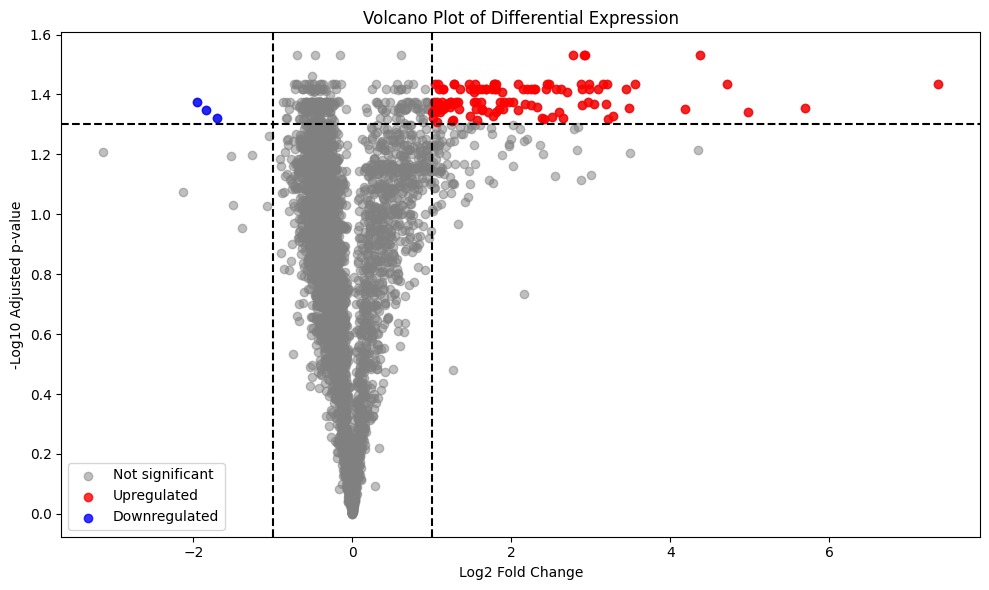

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load results (if not already in memory)
results_path = "/content/drive/MyDrive/MT_Transcriptomics/Results/differential_expression_results.csv"
results_df = pd.read_csv(results_path)

# Define thresholds for significance
log2fc_threshold = 1  # absolute log2 fold change threshold
padj_threshold = 0.05  # adjusted p-value threshold

# Save upregulated genes
sig_up = results_df[(results_df['Log2FoldChange'] > log2fc_threshold) & (results_df['padj'] < padj_threshold)]
sig_up.to_csv('/content/drive/MyDrive/MT_Transcriptomics/Results/upregulated_genes.csv', index=False)

# Save downregulated genes
sig_down = results_df[(results_df['Log2FoldChange'] < -log2fc_threshold) & (results_df['padj'] < padj_threshold)]
sig_down.to_csv('/content/drive/MyDrive/MT_Transcriptomics/Results/downregulated_genes.csv', index=False)

# Create volcano plot
plt.figure(figsize=(10,6))

# Scatter plot of all points
plt.scatter(
    results_df['Log2FoldChange'],
    -np.log10(results_df['padj']),
    color='grey', alpha=0.5, label='Not significant'
)

# Highlight significantly upregulated genes
plt.scatter(
    sig_up['Log2FoldChange'],
    -np.log10(sig_up['padj']),
    color='red', alpha=0.8, label='Upregulated'
)

# Highlight significantly downregulated genes
plt.scatter(
    sig_down['Log2FoldChange'],
    -np.log10(sig_down['padj']),
    color='blue', alpha=0.8, label='Downregulated'
)

plt.axvline(x=log2fc_threshold, color='black', linestyle='--')
plt.axvline(x=-log2fc_threshold, color='black', linestyle='--')
plt.axhline(y=-np.log10(padj_threshold), color='black', linestyle='--')

plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted p-value')
plt.title('Volcano Plot of Differential Expression')
plt.legend()
plt.tight_layout()

# Save plot to file
plt.savefig('/content/drive/MyDrive/MT_Transcriptomics/Results/volcano_plot.png', dpi=300)

plt.show()
